# Titanic Kaggle

Worked example for the Titanic Kaggle competition: https://www.kaggle.com/c/titanic

0. Import libraries & create helper functions
1. Import & look at data
2. Prepare categorical data
3. Prepare numerical data
4. Create model
5. Train model
6. ???
7. Profit

## Imports & methods for plotting graphs

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import math

from keras import backend
from keras import Input

from keras.layers import concatenate, Dense, BatchNormalization
from keras.models import Model, Sequential

# for generating a png image of our model
from keras.utils import plot_model
from IPython.display import Image

Using Theano backend.


In [2]:
# disable the `SettingWithCopy` because we are pretty sure we know what we are doing
pd.set_option('mode.chained_assignment', None) 

In [3]:
# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)
# method taken from `Deep Learning with Python` by François Chollet

def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [4]:
# Plot model history more easily

def set_plot_history_data(ax, history, which_graph):

    if which_graph == 'acc':
        train = smooth_curve(history.history['acc'])
        valid = smooth_curve(history.history['val_acc'])

    if which_graph == 'loss':
        train = smooth_curve(history.history['loss'])
        valid = smooth_curve(history.history['val_loss'])

    plt.xkcd() # make plots look like xkcd
        
    epochs = range(1, len(train) + 1)
        
    trim = 5 # remove first 5 epochs
    # when graphing loss the first few epochs may skew the (loss) graph
    
    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', label=('Training'))
    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', linewidth=15, alpha=0.1)
    
    ax.plot(epochs[trim:], valid[trim:], 'g', label=('Validation'))
    ax.plot(epochs[trim:], valid[trim:], 'g', linewidth=15, alpha=0.1)

    
def get_max_validation_accuracy(history):
    validation = smooth_curve(history.history['val_acc'])
    ymax = max(validation)
    return 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'

In [5]:
def plot_history(history):    
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,
                                   ncols=1,
                                   figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw = {'height_ratios':[5, 2]})

    set_plot_history_data(ax1, history, 'acc')
    
    set_plot_history_data(ax2, history, 'loss')
    
    # Accuracy graph
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(bottom=0.5, top=1)
    ax1.legend(loc="lower right")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_ticks_position('none')
    ax1.spines['bottom'].set_visible(False)
    
    # max accuracty text
    plt.text(0.97,
             0.97,
             get_max_validation_accuracy(history),
             horizontalalignment='right',
             verticalalignment='top',
             transform=ax1.transAxes,
             fontsize=12)

    # Loss graph
    ax2.set_ylabel('Loss')
    ax2.set_yticks([])
    ax2.plot(legend=False)
    ax2.set_xlabel('Epochs')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()

## Let's begin!

In [6]:
# labeled data
titanic_path = 'train.csv'

# unlabeled data -- we'll need to predict this data
titanic_unlabeled = 'test.csv'

df = pd.read_csv(titanic_path, quotechar='"')

predict = pd.read_csv(titanic_unlabeled, quotechar='"')

In [7]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
labeled_rows = len(df)
labeled_rows

891

In [9]:
predict.insert(1, 'Survived', '?');

In [10]:
predict.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,?,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,?,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,?,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,?,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,?,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
frames = [df, predict]
together = pd.concat(frames)

In [12]:
together[888:894]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
0,892,?,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,?,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,?,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Keep only desired rows and rearrange for easier view:

In [13]:
preferredOrder = ['PassengerId', 'Sex', 'Pclass', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']
together = together[preferredOrder]

In [14]:
together.head(5)

,PassengerId,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived
0,1,male,3,NaN,S,1,0,22.0,7.2500,0
1,2,female,1,C85,C,1,0,38.0,71.2833,1
2,3,female,3,NaN,S,0,0,26.0,7.9250,1
3,4,female,1,C123,S,1,0,35.0,53.1000,1
4,5,male,3,NaN,S,0,0,35.0,8.0500,0


## Create two new categories: alone & child

In [15]:
together['isalone'] = '?'

def set_is_alone(row):
    if row.SibSp >= 1 or row.Parch >= 1:
        return '0'
    else: 
        return '1'

together['isalone'] = together.apply(set_is_alone, axis=1)

In [16]:
together['ischild'] = '?'

def set_is_child(row):
    if row.Age < 18:
        return '1'
    else:
        return '0'

together['ischild'] = together.apply(set_is_child, axis=1)

In [17]:
# confirm we did what we wanted
together[['SibSp', 'Parch', 'isalone', 'Age', 'ischild']].head(10)

,SibSp,Parch,isalone,Age,ischild
0,1,0,0,22.0,0
1,1,0,0,38.0,0
2,0,0,1,26.0,0
3,1,0,0,35.0,0
4,0,0,1,35.0,0
5,0,0,1,NaN,0
6,0,0,1,54.0,0
7,3,1,0,2.0,1
8,0,2,0,27.0,0
9,1,0,0,14.0,1


In [18]:
together.head(5)

,PassengerId,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived,isalone,ischild
0,1,male,3,NaN,S,1,0,22.0,7.2500,0,0,0
1,2,female,1,C85,C,1,0,38.0,71.2833,1,0,0
2,3,female,3,NaN,S,0,0,26.0,7.9250,1,1,0
3,4,female,1,C123,S,1,0,35.0,53.1000,1,0,0
4,5,male,3,NaN,S,0,0,35.0,8.0500,0,1,0


In [19]:
together.shape

(1309, 12)

## Prepare categorical data

We will use 6 categories. The four given:
 - Sex
 - Pclass
 - Cabin
 - Embarked
 
as well as the two we created
 - is_child
 - is_alone

In [20]:
# first four columns
categorical_data = preferredOrder[1:5] # ignore `PassengerId`

# and the two we created
categorical_data.append('ischild')
categorical_data.append('isalone')

categorical_data

['Sex', 'Pclass', 'Cabin', 'Embarked', 'ischild', 'isalone']

`Cabin` values need to be placed into categories.

In [21]:
together['Cabin'].values[:20]

array([nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan, 'G6',
       'C103', nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [22]:
def cleanCabin(el):
    if isinstance(el, str):
        return el[:1]
    else:
        return '0'
together['Cabin'] = together['Cabin'].apply(cleanCabin)
together['Cabin'].values[:20]

array(['0', 'C', '0', 'C', '0', '0', 'E', '0', '0', '0', 'G', 'C', '0',
       '0', '0', '0', '0', '0', '0', '0'], dtype=object)

Keras has `to_categorical` method for **one hot encoding** of data, but it requires natural number input.

We will create our own conversion

In [23]:
def convert_to_natural_number(x, temp_dict):
    if x in temp_dict:
        return temp_dict[x]
    else:
        temp_dict[x] = temp_dict['curr_count']
        temp_dict['curr_count'] += 1
        return temp_dict[x]


In [24]:
def categorical_column_to_number(col):
    temp_dict = temp_dict = {'curr_count': 0}
    together[col] = together[col].apply(convert_to_natural_number, args=(temp_dict,))

In [25]:
together[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked,ischild,isalone
0,male,3,0,S,0,0
1,female,1,C,C,0,0
2,female,3,0,S,0,1
3,female,1,C,S,0,0
4,male,3,0,S,0,1
5,male,3,0,Q,0,1
6,male,1,E,S,0,1
7,male,3,0,S,1,0
8,female,3,0,S,0,0
9,female,2,0,C,1,0


In [26]:
for col in categorical_data:
    categorical_column_to_number(col)

In [27]:
together[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked,ischild,isalone
0,0,0,0,0,0,0
1,1,1,1,1,0,0
2,1,0,0,0,0,1
3,1,1,1,0,0,0
4,0,0,0,0,0,1
5,0,0,0,2,0,1
6,0,1,2,0,0,1
7,0,0,0,0,1,0
8,1,0,0,0,0,0
9,1,2,0,1,1,0


Now we are ready to convert data to _one hot encoding_

In [28]:
together.shape

(1309, 12)

In [29]:
newDF = pd.DataFrame()

In [30]:
for col in categorical_data:
    one_hot = pd.get_dummies(together[col])
    one_hot = one_hot.add_prefix(col)
    for new_name in list(one_hot):
      newDF[new_name] = one_hot[new_name]

In [31]:
newDF.shape

(1309, 22)

In [32]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin3,Cabin4,...,Cabin7,Cabin8,Embarked0,Embarked1,Embarked2,Embarked3,ischild0,ischild1,isalone0,isalone1
0,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,0,1,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,0,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [33]:
newDF.shape

(1309, 22)

In [34]:
print(list(newDF))

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin3', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Cabin8', 'Embarked0', 'Embarked1', 'Embarked2', 'Embarked3', 'ischild0', 'ischild1', 'isalone0', 'isalone1']


Some columns have too-few elements and we'll drop them - you can't learn from too-few examples (they may be flukes and not statistically representative)

In [35]:
print('Column   \ttotal entrties')
print('-------------------------------')
for col in list(newDF):
    total = newDF[col].sum()
    print(col,':    ', '\t', total, sep='', end='')
    if (total < 10):
        newDF = newDF.drop([col], axis=1)
        print('\t<-- dropped', end='')
    print()

Column   	total entrties
-------------------------------
Sex0:    	843
Sex1:    	466
Pclass0:    	709
Pclass1:    	323
Pclass2:    	277
Cabin0:    	1014
Cabin1:    	94
Cabin2:    	41
Cabin3:    	5	<-- dropped
Cabin4:    	46
Cabin5:    	22
Cabin6:    	65
Cabin7:    	21
Cabin8:    	1	<-- dropped
Embarked0:    	914
Embarked1:    	270
Embarked2:    	123
Embarked3:    	2	<-- dropped
ischild0:    	1155
ischild1:    	154
isalone0:    	519
isalone1:    	790


In [36]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,ischild0,ischild1,isalone0,isalone1
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1


In [37]:
one_hot_columns = list(newDF)
print(one_hot_columns)

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Embarked0', 'Embarked1', 'Embarked2', 'ischild0', 'ischild1', 'isalone0', 'isalone1']


In [38]:
result = pd.concat([newDF, together], axis=1, join_axes=[newDF.index])

In [39]:
result = result.drop(categorical_data, axis=1)

In [40]:
result[one_hot_columns].head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,ischild0,ischild1,isalone0,isalone1
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1


## Prepare numerical data

We will use these 4 as numbers:
 - SibSp (# of **sib**lings / # of **sp**ouses)
 - Parch (# of **par**ent / # of **ch**ildren)
 - Age
 - Fare

In [41]:
numerical_data = preferredOrder[5:9]
numerical_data

['SibSp', 'Parch', 'Age', 'Fare']

In [42]:
def normalize(x, colMax, colMean):
    if math.isnan(x):
        return 0
        # I have seen this approach instead but don't think it yields better results
        # return colMean
    if isinstance(x, float):
        return x / colMax
    elif isinstance(x, int):
        return float(x) / colMax
    else:
        return 0

In [43]:
def applyNormalize(col):
    column_max = result[col].max()
    column_mean = result[col].mean()
    result[col] = result[col].apply(normalize, args=(column_max, column_mean))

In [44]:
for col in numerical_data:
    applyNormalize(col)

In [45]:
result[numerical_data].head(3)

,SibSp,Parch,Age,Fare
0,0.125,0.0,0.275,0.014151
1,0.125,0.0,0.475,0.139136
2,0.000,0.0,0.325,0.015469


In [46]:
result[numerical_data].describe()

,SibSp,Parch,Age,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.062357,0.042781,0.298469,0.064939
std,0.130207,0.096173,0.219886,0.101004
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.087500,0.015412
50%,0.000000,0.000000,0.300000,0.028213
75%,0.125000,0.000000,0.437500,0.061045
max,1.000000,1.000000,1.000000,1.000000


Notice that max is now 1

## Split data for training

In [47]:
result[one_hot_columns].head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,ischild0,ischild1,isalone0,isalone1
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1


In [48]:
result[numerical_data].head(5)

,SibSp,Parch,Age,Fare
0,0.125,0.0,0.2750,0.014151
1,0.125,0.0,0.4750,0.139136
2,0.000,0.0,0.3250,0.015469
3,0.125,0.0,0.4375,0.103644
4,0.000,0.0,0.4375,0.015713


**Randomize the order of all the rows**

_this is important because the original data may not be (and in this case is not) random_

In [49]:
rows_to_predict = result[labeled_rows:]

In [50]:
rows_to_predict.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,...,ischild0,ischild1,isalone0,isalone1,PassengerId,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,892,0.000,0.000000,0.43125,0.015282,?
1,0,1,1,0,0,1,0,0,0,0,...,1,0,1,0,893,0.125,0.000000,0.58750,0.013663,?
2,1,0,0,0,1,1,0,0,0,0,...,1,0,0,1,894,0.000,0.000000,0.77500,0.018909,?
3,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,895,0.000,0.000000,0.33750,0.016908,?
4,0,1,1,0,0,1,0,0,0,0,...,1,0,1,0,896,0.125,0.111111,0.27500,0.023984,?


In [51]:
result = result[:labeled_rows].sample(frac=1)

In [52]:
result.shape

(891, 25)

In [53]:
x_cat_all = result[one_hot_columns]
x_num_all = result[numerical_data]

y_data_all = result['Survived']

In [54]:
# Here is how you can manually split the data into training & validation
# later we will use Keras's native method (making this process very simple)

# 80% for training, the rest for validation
cutoff = round(0.8 * len(x_cat_all)) 

# training
x_cat = x_cat_all[:cutoff]
x_num = x_num_all[:cutoff]
y_train = y_data_all[:cutoff]

# validation
x_cat_val = x_cat_all[cutoff:]
x_num_val = x_num_all[cutoff:]
y_validation = y_data_all[cutoff:]

In [55]:
print('left input:', len(one_hot_columns))
print('right input:', len(numerical_data))

left input: 19
right input: 4


In [56]:
x_cat.shape

(713, 19)

In [57]:
x_num.shape

(713, 4)

## Build two-input model

In [58]:
# backend.clear_session()

# categorical branch -- 'left'
left_in = Input(shape=(19,), name='categorical input')

left1  = Dense(64, activation='relu')(left_in)
left1n = BatchNormalization()(left1)
left2  = Dense(32, activation='relu')(left1n)
left2n = BatchNormalization()(left2)
left3  = Dense(16, activation='relu')(left2n)
left3n = BatchNormalization()(left3)
left4  = Dense(8,  activation='relu')(left3n)
left4n = BatchNormalization()(left4)
left5  = Dense(4,  activation='relu')(left4n)

left_out  = Dense(1, activation='sigmoid')(left5)

# numerical branch -- 'right'
right_in = Input(shape=(4,), name='numerical input')

right1  = Dense(64, activation='relu')(right_in)
right1a = BatchNormalization()(right1)
right2  = Dense(32, activation='relu')(right1a)
right2a = BatchNormalization()(right2)
right3  = Dense(16, activation='relu')(right2a)
right3a = BatchNormalization()(right3)
right4  = Dense(8,  activation='relu')(right3a)
right4a = BatchNormalization()(right4)
right5  = Dense(4,  activation='relu')(right4a)

right_out = Dense(1, activation='sigmoid')(right5)

# merge two branches
merge_in = concatenate([left_out, right_out])

dense1  = Dense(16, activation='relu')(merge_in)
dense2  = Dense(8,  activation='relu')(dense1)
dense2a = BatchNormalization()(dense2)
dense3  = Dense(8,  activation='relu')(dense2a)

output  = Dense(1, activation='sigmoid')(dense3)

model_new = Model(inputs=[left_in, right_in], outputs=output)

model_new.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# model_new.summary()

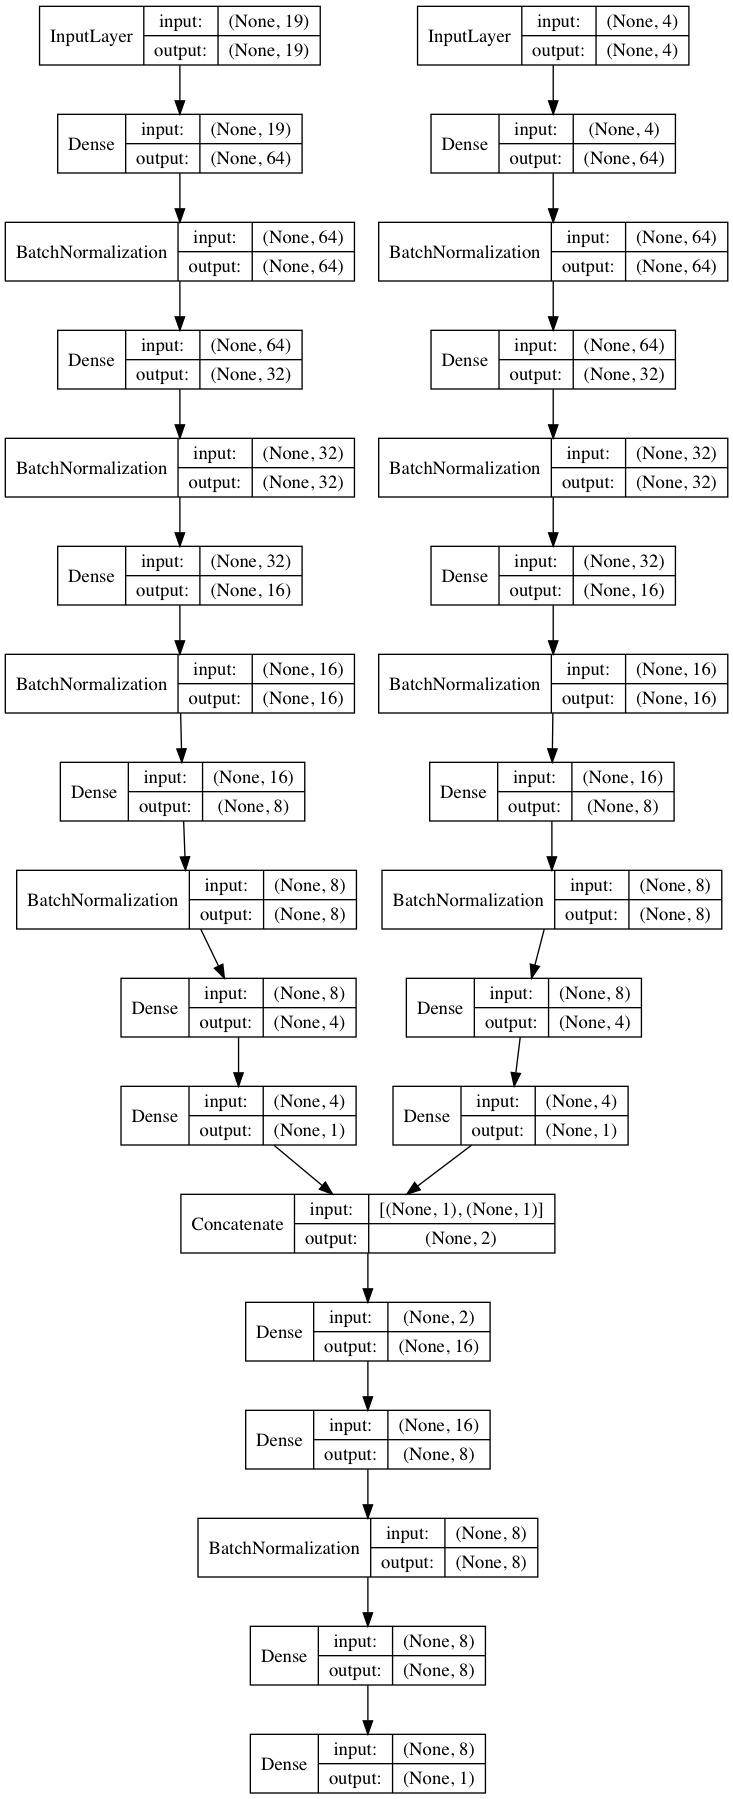

In [59]:
plot_model(model_new, show_shapes=True, to_file='model.png', show_layer_names=False)
Image('model.png', width=200)

In [60]:
history_final = model_new.fit([x_cat, x_num],
                              y_train,
                              epochs=150,
                              verbose=0,
                              batch_size=64,
                              validation_data=([x_cat_val, x_num_val], y_validation))

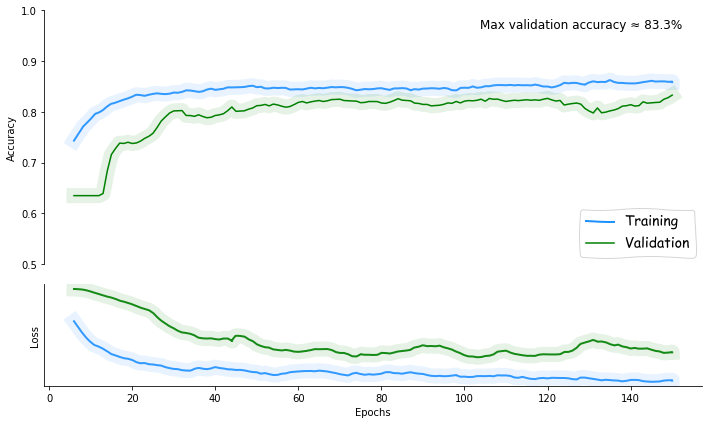

In [61]:
plot_history(history_final)

Can be as high as 83% accurate

In [62]:
# model_new.save('model_new.h5')

# Alternative approach
Build two models, train them, and then build a third to fuse the two

## Built categorical model

In [63]:
x_data = result[one_hot_columns]
y_data = result['Survived']

In [64]:
print('Number of inputs:', len(one_hot_columns))

Number of inputs: 19


In [65]:
result[one_hot_columns].shape

(891, 19)

In [66]:
# backend.clear_session()

model_cat = Sequential()

model_cat.add(Dense(64, activation='relu', input_shape=(19,)))
model_cat.add(Dense(32, activation='relu'))
model_cat.add(BatchNormalization())
model_cat.add(Dense(16, activation='relu'))
model_cat.add(BatchNormalization())
model_cat.add(Dense(8, activation='relu'))
model_cat.add(BatchNormalization())
model_cat.add(Dense(4, activation='relu'))
model_cat.add(BatchNormalization())
# model_cat.add(Dense(8, activation='relu'))
# model_cat.add(Dense(4, activation='relu'))
# model_cat.add(Dense(8, activation='relu'))
# model_cat.add(Dense(32, activation='relu'))
model_cat.add(Dense(1, activation='sigmoid'))

model_cat.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# model_cat.summary()

## Train categorical

Note that unlike in the previous example, we are using Keras's method 
```
validation_split=0.2
```
instead of explicit validation
```
validation_data=(x_validation, y_validation)
```

In [67]:
history_cat = model_cat.fit(x_data,
                            y_data,
                            validation_split=0.2,
                            epochs=150,
                            batch_size=64,
                            verbose=0)

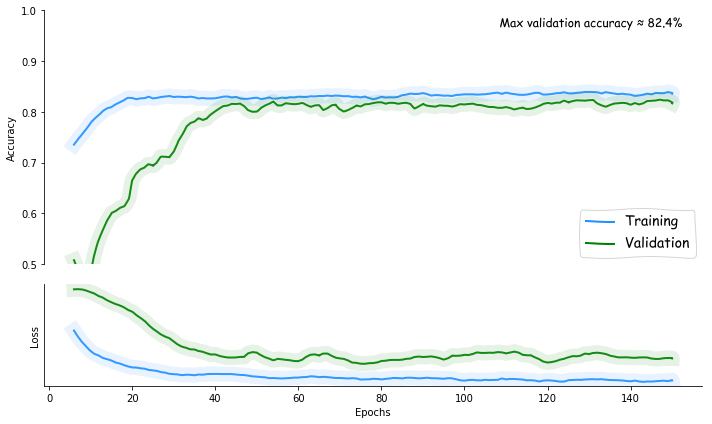

In [68]:
plot_history(history_cat)

Can be as high as 82%

## Build numerical

In [69]:
result[numerical_data].head(5)

,SibSp,Parch,Age,Fare
107,0.000,0.0,0.0000,0.015176
391,0.000,0.0,0.2625,0.015216
142,0.125,0.0,0.3000,0.030937
566,0.000,0.0,0.2375,0.015412
695,0.000,0.0,0.6500,0.026350


Split validation & training data

In [70]:
x_data = result[numerical_data]
y_data = result['Survived']

In [71]:
# backend.clear_session()

from keras.layers import Dropout

model_num = Sequential()

model_num.add(Dense(64, activation='relu', input_shape=(4,)))
model_num.add(Dropout(0.1))
model_num.add(Dense(32, activation='relu'))
model_num.add(Dropout(0.1))
model_num.add(Dense(16, activation='relu'))
model_num.add(Dropout(0.1))
model_num.add(Dense(8, activation='relu'))
model_num.add(Dense(4, activation='relu'))
# model_num.add(Dense(8, activation='relu'))
# model_num.add(Dense(4, activation='relu'))
# model_num.add(Dense(32, activation='relu'))
model_num.add(Dense(1, activation='sigmoid'))

model_num.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# model_num.summary()

## Train numerical

In [72]:
history_num = model_num.fit(x_data,
                            y_data,
                            epochs=300,
                            batch_size=len(x_data),
                            verbose=0,
                            validation_split=0.2)

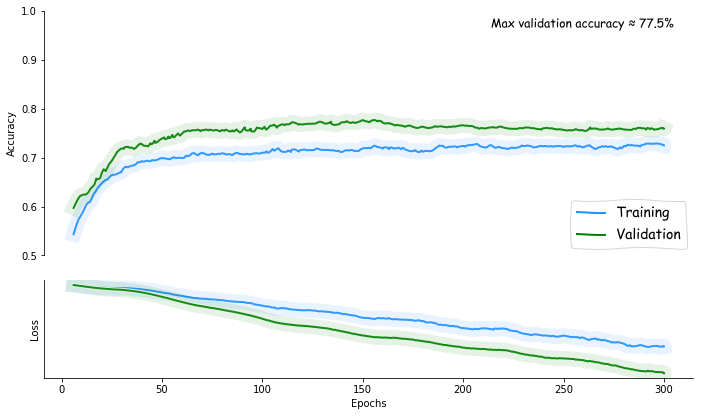

In [73]:
plot_history(history_num)

Can be as high as 77%

## Merge the two models

In [74]:
# one option is to freeze the first two models
# model_cat.trainable = False
# model_num.trainable = False
# but we will not
model_cat.trainable = True
model_num.trainable = True

In [75]:
merge = concatenate([model_num.output, model_cat.output])

# d1 =  Dense(8, activation='relu')(merge)
# # d1n = BatchNormalization()(d1)
# d2 =  Dense(16, activation='relu')(d1)
# # d2n = BatchNormalization()(d2)
# d3 =  Dense(8, activation='relu')(d2)
# # d3n = BatchNormalization()(d2)
# d4 =  Dense(4, activation='relu')(d3)

output = Dense(1, activation='sigmoid')(merge)

joint_model = Model(inputs=[model_num.input, model_cat.input], outputs=output)

joint_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# joint_model.summary()

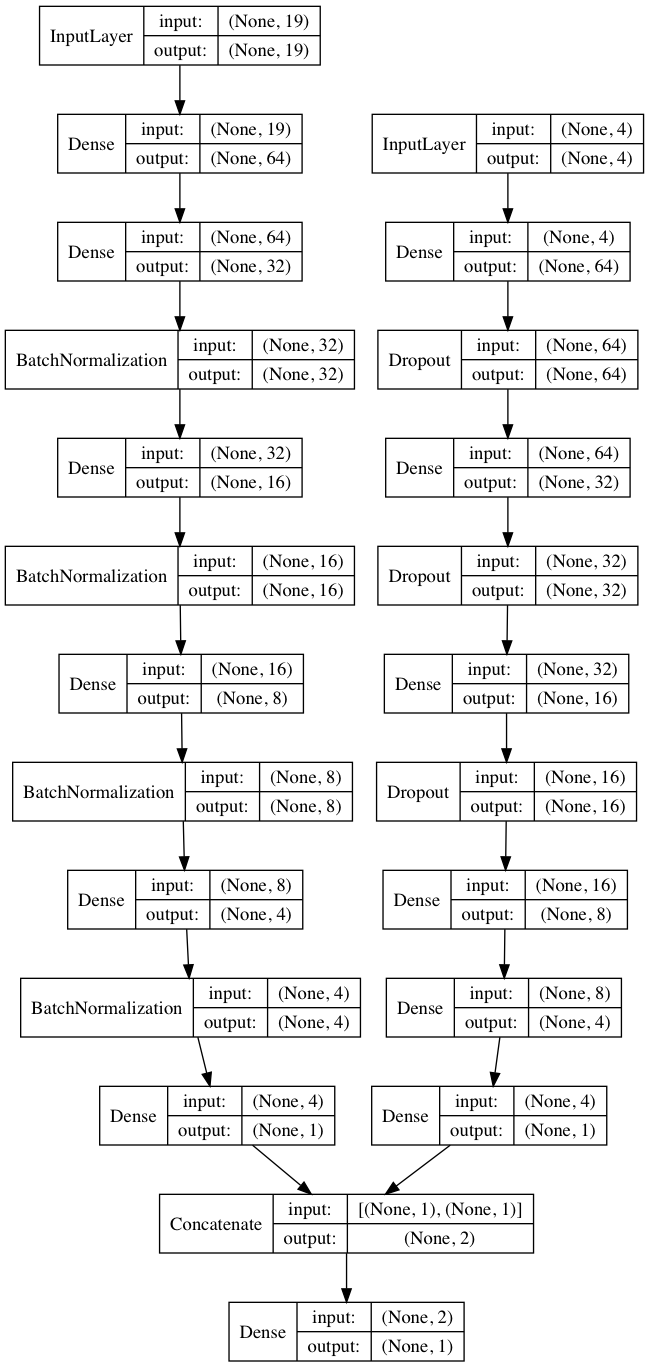

In [76]:
plot_model(joint_model, show_shapes=True, to_file='model2.png', show_layer_names=False)
Image('model2.png', width=200)

Prepare checkpoint method for storing the best model

In [77]:
from keras.callbacks import ModelCheckpoint

In [78]:
filepath="{val_acc:.2f}-accuracy.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode='max')

callbacks_list = [checkpoint]

In [79]:
history_final = joint_model.fit([x_num, x_cat],
                                y_train,
                                epochs=300,
                                verbose=0,
                                batch_size=len(x_num),
                                callbacks=callbacks_list,
                                validation_split=0.2)

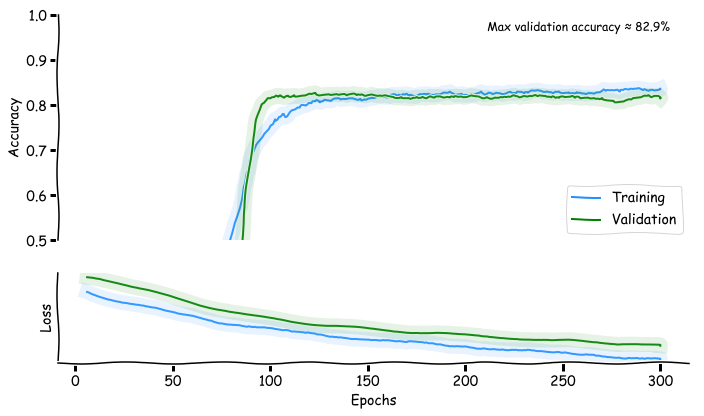

In [80]:
plot_history(history_final)

Can be as high as 87%

In [81]:
# joint_model.save('joint_model.h5')

## Predict unlabeled data

In [82]:
from keras.models import load_model

In [83]:
loaded_model = load_model('0.84-accuracy.h5')

In [84]:
rows_to_predict.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,...,ischild0,ischild1,isalone0,isalone1,PassengerId,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,892,0.000,0.000000,0.43125,0.015282,?
1,0,1,1,0,0,1,0,0,0,0,...,1,0,1,0,893,0.125,0.000000,0.58750,0.013663,?
2,1,0,0,0,1,1,0,0,0,0,...,1,0,0,1,894,0.000,0.000000,0.77500,0.018909,?
3,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,895,0.000,0.000000,0.33750,0.016908,?
4,0,1,1,0,0,1,0,0,0,0,...,1,0,1,0,896,0.125,0.111111,0.27500,0.023984,?


In [85]:
rows_to_predict.shape

(418, 25)

In [86]:
passenger_ids_to_predict = rows_to_predict['PassengerId']

In [87]:
prediction = loaded_model.predict([rows_to_predict[numerical_data], rows_to_predict[one_hot_columns]])

In [88]:
prediction.shape

(418, 1)

In [89]:
prediction[:10]

array([[ 0.48791045],
       [ 0.4923934 ],
       [ 0.48370972],
       [ 0.49038923],
       [ 0.49819094],
       [ 0.49628195],
       [ 0.57938915],
       [ 0.49692136],
       [ 0.58874506],
       [ 0.4887957 ]], dtype=float32)

In [90]:
prediction = (prediction > 0.5).astype(int).reshape(-1)

In [91]:
prediction[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [92]:
submission = pd.DataFrame({"PassengerId": passenger_ids_to_predict, "Survived": prediction})
submission.to_csv('submission.csv', index=False)

# Archive

## Archive: Keras one-hot method

In [93]:
from keras.utils import to_categorical

In [95]:
for col in categorical_data:
    print(col)
    lol = (to_categorical(together[col]))
    print(lol[:5])

Sex
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Pclass
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
Cabin
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Embarked
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]
ischild
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
isalone
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


## Archive: another way to visually see your model

This method does not create a .png file and will render directly to Jupyter (but result will not be as detailed or pretty)

*note*: you'll need to install `graphviz` externally for this diagram to be generated

In [96]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model_new).create(prog='dot', format='svg'))

## Archive: another way to plot
simpler code but less pretty

In [97]:
def plot_this(training, validation, label):
    
    epochs = range(1, len(training) + 1)
    
    plt.clf() # clear out old
    
    plt.xkcd() # make look like xkcd
    
    # plt.figure(figsize=(8, 3)) # make wider
    
    trim = 10 # remove first 10 data points

    plt.plot(epochs[trim:], training[trim:], 'b', label=('Training '+label))
    plt.plot(epochs[trim:], validation[trim:], 'g', label=('Validation '+label))
    plt.title('Model ' + label)
    plt.xlabel('Epochs')
    plt.ylabel(label)
    
    if label == 'Loss':
        plt.yticks([])
        
    if label == 'Accuracy':
        plt.ylim(ymin=0.5)
        plt.ylim(ymax=1)
        ymax = max(validation[trim:])
        best = 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'
        plt.text(0, 0.35, best, fontsize=12)
        
    plt.legend()

    return plt

In [98]:
def plot_history_old(history):

    label1 = 'Loss'
    train1 = smooth_curve(history.history['loss'])
    valid1 = smooth_curve(history.history['val_loss'])

    plot_this(train1, valid1, label1).show()
    
    label2 = 'Accuracy'
    train2 = smooth_curve(history.history['acc'])
    valid2 = smooth_curve(history.history['val_acc'])
    
    plot_this(train2, valid2, label2).show()

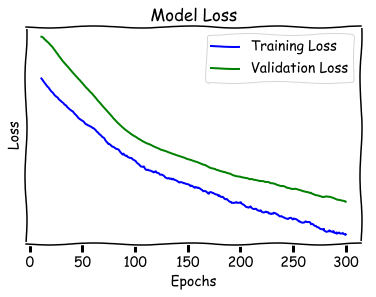

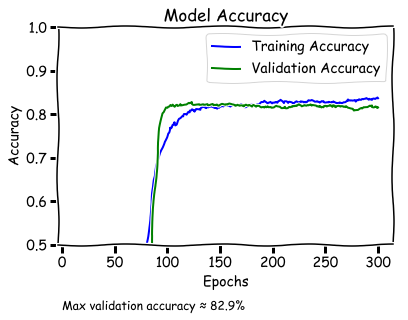

In [99]:
plot_history_old(history_final)

## Archive: plot with seaborn

In [100]:
import seaborn as sns

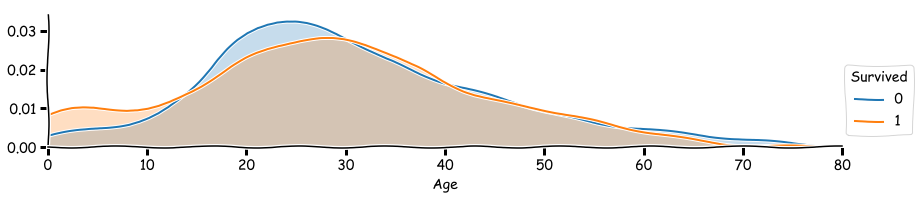

In [101]:
facet = sns.FacetGrid(df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()